In [1]:
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
import os
import skimage
from scipy.ndimage.filters import gaussian_filter1d

import step_detect
import scalarizer

/var/folders/wk/3nz2fl4n6qvdt2sv1j8wvwrc0000gn/T/ipykernel_5626/3356064319.py:6: DeprecationWarning: Please use `gaussian_filter1d` from the `scipy.ndimage` namespace, the `scipy.ndimage.filters` namespace is deprecated.
  from scipy.ndimage.filters import gaussian_filter1d


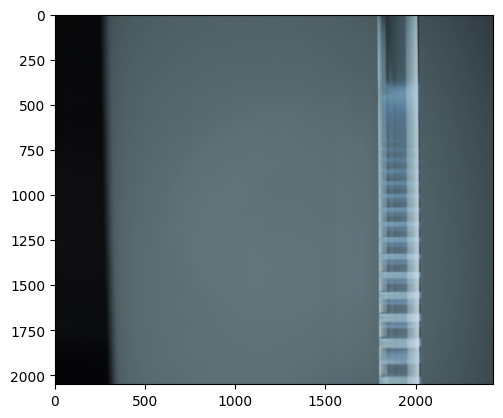

In [2]:
imgfile = '102808_67_2025-02-16_0333.Jpg'
img = skimage.io.imread(imgfile)
plt.imshow(img)

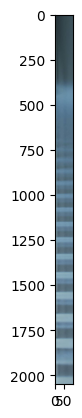

In [4]:
#Locate the tube in the image and select a subregion for integration

#Camera specific values:
vialCenterBuffer = 90 
vialIntegrateWidth = 100
skewLeft = 25

###
frame1d_vert = np.average(img, axis = -1)
frame1d_vert = np.average(frame1d_vert, axis = 0)

guass_filtered = gaussian_filter1d(frame1d_vert[1000:], 3, order=1)
guass_filtered = guass_filtered/max(guass_filtered)

steps = step_detect.find_steps(guass_filtered, 0.5)
left = steps[0]+1000
right = steps[-1]+1000
vialWidthMeas = right-left

region = img[:, int(left+ vialWidthMeas/2 - vialIntegrateWidth/2 - skewLeft) : int(left+ vialWidthMeas/2 + vialIntegrateWidth/2 - skewLeft) ]

plt.imshow(region)

In [5]:
#Scalarizer core function, automatic band detection 
pos,neg,topEdges, botEdges, bandwidths = scalarizer.locateBands(region, superscale=4)

Text(0, 0.5, 'Distance (mm)')

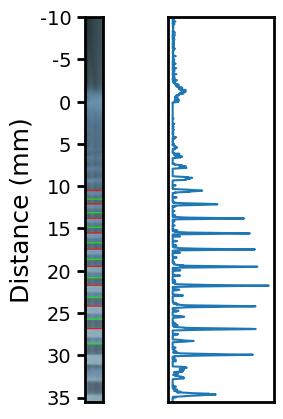

In [6]:
fig, ax = plt.subplots(1,2, figsize=(3,5))
px_per_mm = 54
upscaled = 4

drawregion = region.copy()


for top in topEdges:
    drawregion[int(top/upscaled)-3:int(top/upscaled)+2,:] = (255,0,0)
for bot in botEdges:
    drawregion[int(bot/upscaled)-3:int(bot/upscaled)+2,:] = (0,255,0)


ax[0].imshow(drawregion)
ax[1].plot(pos, np.array(range(len(pos), 0, -1))/px_per_mm)


ax[0].tick_params( axis='x', which='both', bottom=False, top=False,labelbottom=False)
ax[1].tick_params( axis='both',which='both',bottom=False, top=False,labelbottom=False)

ax[1].set_yticks([])
ax[0].set_yticks(np.arange(0,2026,225)) #px per mm = 54.1
ax[0].set_yticklabels([-10,-5,0,5,10,15,20,25,30,35])
ax[1].set_ylim(0, len(pos)/px_per_mm)

for axis in ['top','bottom','left','right']:
    ax[0].spines[axis].set_linewidth(2)
    ax[1].spines[axis].set_linewidth(2)
    ax[0].tick_params(length = 6, width = 2, labelsize = 14)
    ax[0].tick_params(which='minor', length=4, width =2 )

ax[0].set_ylabel('Distance (mm)', fontsize = 18)


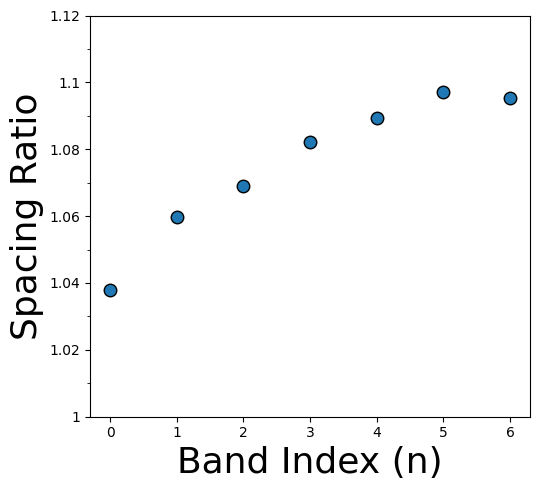

In [7]:

fig, ax = plt.subplots(1,1, figsize=(5.5,5))

def format_sig_figs(x, pos=None):
    return f'{x:.3g}' # 2 sig figs

bands_mm = np.array(topEdges)/px_per_mm/upscaled

spacings_mm = scalarizer.spacingsFromSteps(bands_mm)
ratios = scalarizer.ratiosFromSpacings(spacings_mm)

ax.plot(ratios, lw = 0,ms = 9, marker = 'o', mec = 'black')

ax.set_xlabel('Band Index (n)', fontsize = 26)
ax.set_ylabel('Spacing Ratio', fontsize = 26)
ax.set_ylim((1,1.12))
ax.set_xticks([0,1,2,3,4,5,6])

ax.yaxis.set_minor_locator(mpl.ticker.MultipleLocator(0.01))
ax.yaxis.set_major_locator(mpl.ticker.MultipleLocator(0.02))

ax.yaxis.set_major_formatter(mpl.ticker.FuncFormatter(format_sig_figs))

plt.tight_layout()

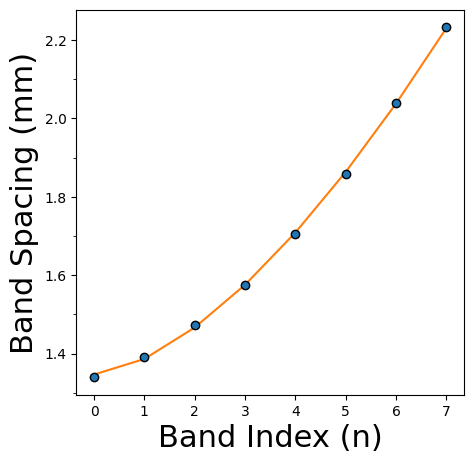

In [12]:
fig, ax = plt.subplots(1,1, figsize=(5,5))

ax.set_xlabel('Band Index (n)', fontsize = 22)
ax.set_ylabel('Band Spacing (mm)', fontsize = 22)
#ax.set_ylim(1.5,2.8)

ax.set_xticks([0,1,2,3,4,5,6,7])

ax.yaxis.set_minor_locator(mpl.ticker.MultipleLocator(0.1))
ax.yaxis.set_major_locator(mpl.ticker.MultipleLocator(0.2))
res, X, Y = scalarizer.powerfit(spacings_mm)
popt, pcov = res

ax.plot(scalarizer.powerfunc(X, *popt), color = 'tab:orange', label = "Ae$^{Bx}+C$ Fit")
ax.plot(np.array(spacings_mm), marker = 'o', lw = 0, mec = 'black', label = 'Spacing')
